## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 46.6%
RAM Usage: 47.8%
Available RAM: 196.8G
Total RAM: 376.8G
52.4G


## Wandb API Query <a id="sims"></a>

Basic test

In [5]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'cge'
cv_type = 'random'
null_model = 'none'
feature_type = 'transcriptome_PCA'

time_filter = datetime.now() - timedelta(days=7)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 40 runs
Columns: ['run_name', 'train_geodesic_distance', 'train_inter_hemi_r', 'train_inter_network_Cerebellum_r', 'train_inter_network_Cont_r', 'train_inter_network_Default_r', 'train_inter_network_DorsAttn_r', 'train_inter_network_Limbic_r', 'train_inter_network_SalVentAttn_r', 'train_inter_network_SomMot_r', 'train_inter_network_Subcortical_r', 'train_inter_network_Vis_r', 'train_intra_network_Cerebellum_r', 'train_intra_network_Cont_r', 'train_intra_network_Default_r', 'train_intra_network_DorsAttn_r', 'train_intra_network_Limbic_r', 'train_intra_network_SalVentAttn_r', 'train_intra_network_SomMot_r', 'train_intra_network_Subcortical_r', 'train_intra_network_Vis_r', 'train_left_hemi_r', 'train_long_r', 'train_mae', 'train_mid_r', 'train_mse', 'train_pearson_r', 'train_r2', 'train_right_hemi_r', 'train_short_r', 'train_spearman_r', 'train_strong_neg_r', 'train_strong_pos_r', 'train_weak_r', 'test_geodesic_distance', 'test_inter_hemi_r', 'test_inter_network_Ce

Find individual runs

In [6]:
import wandb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

api = wandb.Api()
project_path = "alexander-ratzan-new-york-university/gx2conn"

def fetch_and_summarize_wandb_runs_schaefer(model, null_model, feature_type, days=7):
    """
    Fetches wandb runs for cv_type='schaefer' and summarizes their final train/test metrics.
    If more than 9 runs are found, keeps only one per run_name with highest test pearson_r.
    
    Args:
        model (str): Model name
        null_model (str): Null model label, e.g., 'none' or 'spin'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        days (int): Number of past days to search within
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
    """
    time_filter = datetime.now() - timedelta(days=days)
    cv_type = "schaefer"
    
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}"
            ]
        },
        "created_at": {"$gte": time_filter.isoformat()},
        "state": "finished"
    }
    
    print(f"🔍 Fetching runs for: model={model}, cv_type=schaefer, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    if len(df) < 9:
        raise ValueError(f"❌ Expected 9 runs, but found {len(df)}.")

    # Deduplicate by run_name using highest test pearson_r
    df_unique = (
        df.sort_values("final_test_pearson_r", ascending=False)
          .drop_duplicates("run_name", keep="first")
    )

    if len(df_unique) != 9:
        raise ValueError(f"❌ Expected 9 unique run names, found {len(df_unique)} after deduplication.")

    df_clean = df_unique.drop(columns=["run_name", "run_id", "final_test_pearson_r"], errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T

    return summary_df


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_barchart(summary_dict, metric="test_pearson_r", model_groups=None, xlim=(0.1, 0.9)):
    """
    Create a horizontal bar plot of model performance with error bars, ordered by descending mean.
    """
    if model_groups is None:
        model_groups = {
            'Non-Linear': {
                'dynamic_mlp': 'Deep Neural Net',
                'shared_transformer': 'SMT',
                'shared_transformer_cls': 'SMT w/ [CLS]'
            },
            'Bilinear': {
                'bilinear_CM': 'CM',
                'bilinear_CM_PCA': 'CM (PCA)',
                'pls_bilineardecoder': 'CM (PLS)',
                'bilinear_lowrank': 'CM (Low-Rank)'},
            'Feature Based': {
                'cge': 'CGE',
                'gaussian_kernel': 'Gaussian Kernel', 
                'exponential_decay': 'Exponential Decay'
            }
        }
    else:
        # Convert list-based model_groups to dict format
        formatted_groups = {}
        for group_name, models_list in model_groups.items():
            formatted_groups[group_name] = {
                model: model.replace('_', ' ').title() 
                for model in models_list
            }
        model_groups = formatted_groups

    # Set global font size and derived sizes
    base_fontsize = 20
    plt.rcParams.update({'font.size': base_fontsize})
    label_fontsize = base_fontsize * 0.67  # ~12
    legend_fontsize = base_fontsize * 0.78  # ~14

    # Flatten model info into DataFrame
    plot_data = []
    for group_name, model_dict in model_groups.items():
        for model_key, model_display in model_dict.items():
            if model_key in summary_dict:
                df = summary_dict[model_key]
                if metric in df.columns:
                    plot_data.append({
                        "Model": model_display,
                        "Group": group_name,
                        "Mean": df.loc["mean", metric],
                        "StdErr": df.loc["stderr", metric]
                    })

    plot_df = pd.DataFrame(plot_data)

    # Sort by descending mean performance
    plot_df = plot_df.sort_values("Mean", ascending=True)

    # Plot
    plt.figure(figsize=(8, 7), dpi=300)
    ax = sns.barplot(
        data=plot_df,
        y="Model",
        x="Mean",
        hue="Group",
        dodge=False,
        palette=sns.color_palette("viridis", n_colors=8, desat=1.0)[::3],  # Using every 3rd color from 8 viridis colors for more contrast
        errorbar=None
    )

    # Add error bars manually
    for idx, (_, row) in enumerate(plot_df.iterrows()):
        ax.errorbar(
            x=row["Mean"],
            y=idx,
            xerr=row["StdErr"],
            fmt='none',
            ecolor='black',
            capsize=3,
            linewidth=2
        )

    ax.set_xlim(0.1, 1.0)
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlabel("Pearson-r", fontsize=label_fontsize)
    ax.set_ylabel("")
    ax.invert_yaxis()  # best at top, worst at bottom

    # Set tick label sizes relative to base font size
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)

    # Adjust legend with relative font size
    plt.legend(fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    plt.tight_layout()
    plt.show()

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

def plot_true_vs_null_model_barchart(
    summary_true_dict,
    summary_null_dict,
    metric="test_pearson_r",
    model_groups=None,
    xlim=(0.1, 0.9),
    overlay_style="alpha"  # or "hatch"
):
    if model_groups is None:
        model_groups = {
            'Non-Linear': {
                'dynamic_mlp': 'Deep Neural Net',
                'shared_transformer': 'SMT',
                'shared_transformer_cls': 'SMT w/ [CLS]'
            },
            'Bilinear': {
                'bilinear_CM': 'Connectome Model',
                'bilinear_CM_PCA': 'Connectome Model (PCA)',
                'pls_bilineardecoder': 'Connectome Model (PLS)',
                'bilinear_lowrank': 'Connectome Model (LR)'
            },
            'Feature Based': {
                'cge': 'CGE',
                'gaussian_kernel': 'Gaussian Kernel',
                'exponential_decay': 'Exponential Decay'
            }
        }

    base_fontsize = 22
    label_fontsize = base_fontsize * 0.67
    plt.rcParams.update({'font.size': base_fontsize})

    # Prepare plot data
    plot_data = []
    for group_name, model_dict in model_groups.items():
        for model_key, display_name in model_dict.items():
            if model_key in summary_true_dict and model_key in summary_null_dict:
                df_true = summary_true_dict[model_key]
                df_null = summary_null_dict[model_key]
                if metric in df_true.columns and metric in df_null.columns:
                    plot_data.append({
                        "Model": display_name,
                        "Group": group_name,
                        "TrueMean": df_true.loc["mean", metric],
                        "TrueStdErr": df_true.loc["stderr", metric],
                        "NullMean": df_null.loc["mean", metric],
                        "NullStdErr": df_null.loc["stderr", metric]
                    })

    plot_df = pd.DataFrame(plot_data)
    plot_df = plot_df.sort_values("TrueMean", ascending=False).reset_index(drop=True)

    # Color map
    unique_groups = list(model_groups.keys())
    palette = sns.color_palette("viridis", n_colors=12, desat=1.0)[2::4]
    group_color_map = {group: color for group, color in zip(unique_groups, palette)}

    # Plotting
    plt.figure(figsize=(6, 7), dpi=300)
    ax = plt.gca()

    for i, row in plot_df.iterrows():
        y = i
        ax.barh(
            y=y,
            width=row["TrueMean"],
            height=0.6,
            color=group_color_map[row["Group"]],
            edgecolor="black",
            zorder=1
        )
        ax.errorbar(
            x=row["TrueMean"],
            y=y,
            xerr=row["TrueStdErr"],
            fmt='none',
            ecolor='black',
            capsize=1,
            linewidth=1,
            zorder=2
        )

        if i == 0:
            ax.text(
                row["TrueMean"],
                y - 0.4,  # shift upward (adjust spacing if needed)
                f"{row['TrueMean']:.2f}",
                va="bottom",
                ha="center",
                fontsize=label_fontsize,
                color="black"
            )

        if row["Model"] not in ["Gaussian Kernel", "Exponential Decay"]:
            if overlay_style == 'hatch':
                ax.barh(
                    y=y,
                    width=row["NullMean"],
                    height=0.6,
                    facecolor='none',
                    edgecolor='black',
                    hatch="////",
                    linewidth=1,
                    zorder=3
                )
            elif overlay_style == 'alpha':
                ax.barh(
                    y=y,
                    width=row["NullMean"],
                    height=0.6,
                    color="lightgray",
                    edgecolor="black",
                    alpha=0.3,
                    zorder=3
                )
            ax.errorbar(
                x=row["NullMean"],
                y=y,
                xerr=row["NullStdErr"],
                fmt='none',
                ecolor='black',
                capsize=1,
                linewidth=1,
                linestyle='--',
                zorder=4
            )

    ax.set_xlim(*xlim)
    ax.set_xticks(np.arange(xlim[0], xlim[1] + 0.2, 0.2))
    ax.set_xlabel("Pearson-r", fontsize=label_fontsize)
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df["Model"], fontsize=label_fontsize)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=label_fontsize)

    sns.despine()
    plt.tight_layout()
    plt.show()

    return group_color_map  # return for external legend

Search and plot Schaefer

In [9]:
def process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict):
    """Helper function to process model/feature type combinations and populate summary dictionary"""
    print(f"Checking which model/feature type combinations return 9 runs for null_model={null_model}:\n")
    for model in models:
        feature_types = model_feature_types[model]
        for feature_type in feature_types:
            try:
                df = fetch_and_summarize_wandb_runs_schaefer(model, null_model, feature_type, days)
                
                # Handle bilinear_CM split explicitly
                if model == "bilinear_CM" and feature_type == "transcriptome_PCA":
                    summary_dict["bilinear_CM_PCA"] = df
                    print(f"✓ bilinear_CM_PCA: Successfully found 9 runs")
                elif model == "bilinear_CM" and feature_type == "transcriptome":
                    summary_dict["bilinear_CM"] = df
                    print(f"✓ bilinear_CM: Successfully found 9 runs")
                else:
                    summary_dict[model] = df
                    print(f"✓ {model} with {feature_type}: Successfully found 9 runs")

            except ValueError as e:
                print(f"✗ {model} with {feature_type}: {str(e)}")
            except Exception as e:
                print(f"! {model} with {feature_type}: Unexpected error: {str(e)}")


In [10]:
from collections import defaultdict

from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']


# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
}


cv_type = 'schaefer'
null_model = 'none'
days = 3

# Store summary DataFrames
summary_dict_schaefer = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer)


cv_type = 'schaefer'
null_model = 'spin'
days = 3

# Store summary DataFrames
summary_dict_schaefer_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer_spin)

Checking which model/feature type combinations return 9 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

In [11]:
# plot_model_barchart(summary_dict_schaefer, metric="test_pearson_r")

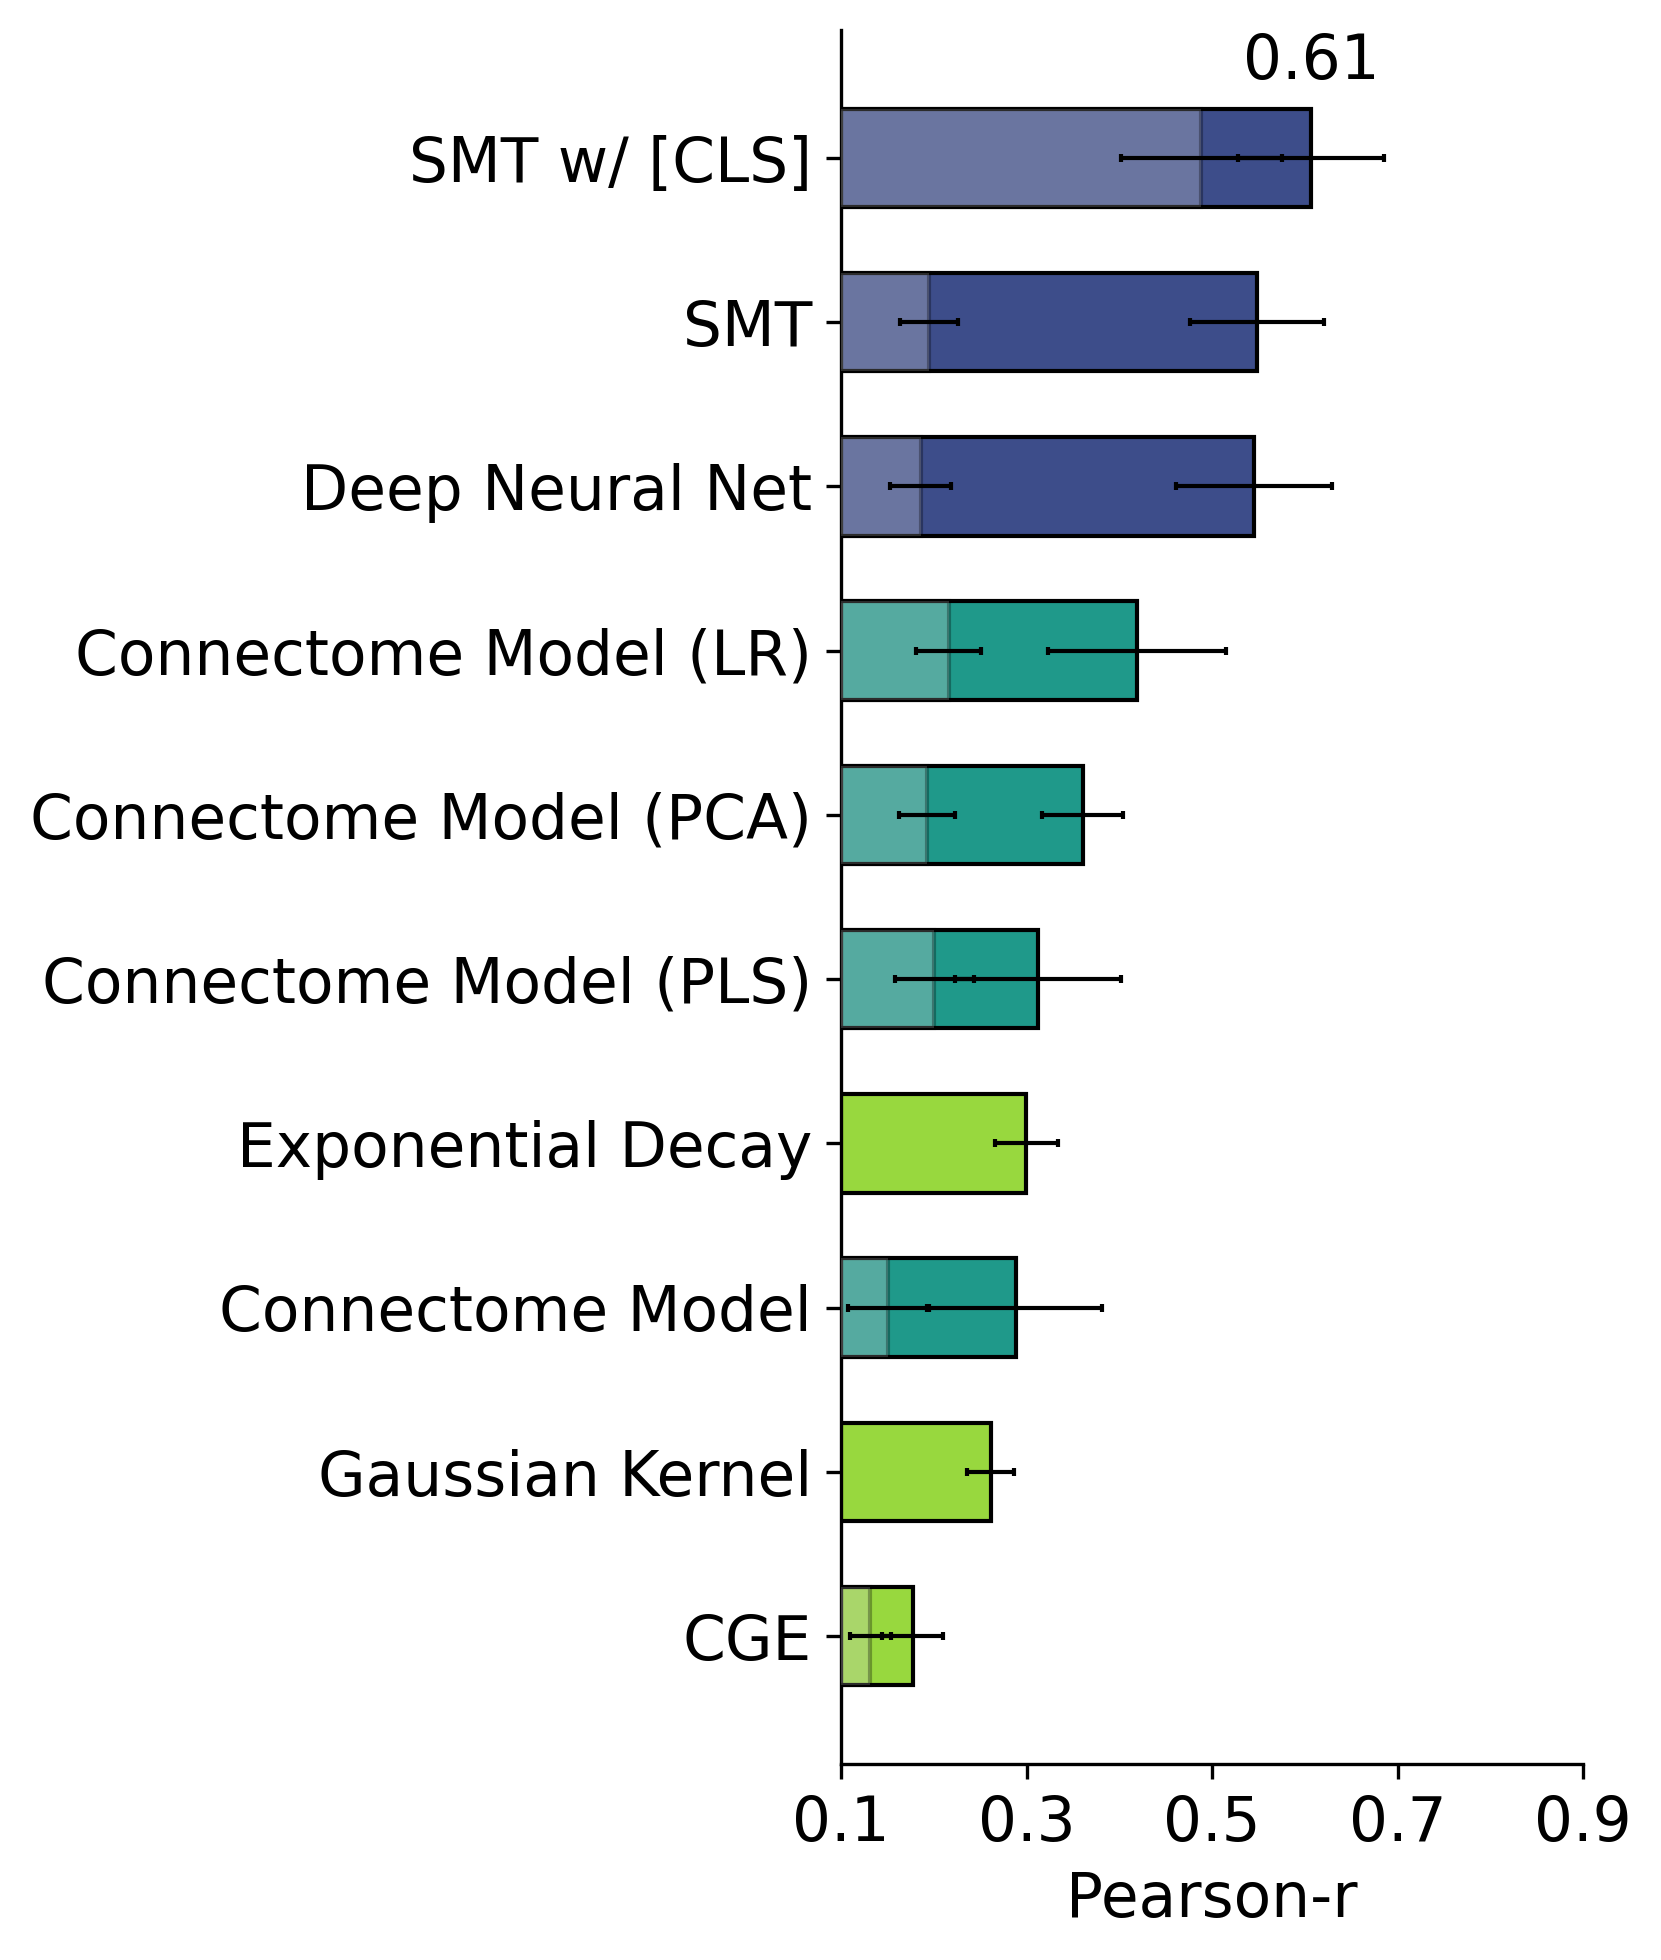

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [12]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_schaefer,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_schaefer_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Continue from here with weighted averaging for schaefer plot... 

In [53]:
def weighted_mean_and_se(values, weights):
    """
    Compute weighted mean and standard error for a set of values and weights.
    
    Args:
        values (np.ndarray): Array of values
        weights (list): List of weights corresponding to each value
        
    Returns:
        tuple: (weighted_mean, weighted_standard_error)
    """
    # Convert to numpy arrays and handle NaN values
    values = np.array(values)
    weights = np.array(weights)[:len(values)]  # Truncate weights to match values length
    
    # Remove NaN values and corresponding weights
    mask = ~np.isnan(values)
    values = values[mask]
    weights = weights[mask]
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Calculate weighted mean
    weighted_mean = np.sum(values * weights)
    
    # Calculate weighted variance
    weighted_var = np.sum(weights * (values - weighted_mean)**2) / (1 - np.sum(weights**2))
    
    # Calculate weighted standard error
    weighted_se = np.sqrt(weighted_var / len(values))
    
    return weighted_mean, weighted_se

def fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, exclude='HCP', days=7, return_history=False):
    """
    Fetches wandb runs for cv_type='schaefer' and returns a DataFrame with each run as a row.
    If more than 9 runs are found, keeps only one per run_name with highest test pearson_r.
    Uses weighted averaging based on network sizes when computing summary statistics.
    
    Args:
        model (str): Model name
        null_model (str): Null model label, e.g., 'none' or 'spin'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        days (int): Number of past days to search within
    
    Returns:
        df (pd.DataFrame): DataFrame with each run as a row containing train/test metrics
    """
    time_filter = datetime.now() - timedelta(days=days)
    cv_type = "schaefer"
    
    # Network sizes for weighted averaging
    network_sizes = {
        'Vis': 61, 
        'SomMot': 77,
        'DorsAttn': 46, 
        'SalVentAttn': 47,
        'Limbic': 26,
        'Cont': 52,
        'Default': 91,
        'Subcortical': 46,
        'Cerebellum': 9
    }
    weights = list(network_sizes.values())
    
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}"
            ], 
            "$nin": [f"dataset_{exclude}"]  # Exclude any runs tagged with dataset_HCP
        },
        "created_at": {"$gte": time_filter.isoformat()},
        "state": "finished"
    }
    
    print(f"🔍 Fetching runs for: model={model}, cv_type=schaefer, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        # Extract fold number from run name
        fold_match = re.search(r'fold(\d+)', run.name)
        if fold_match:
            metrics['fold'] = int(fold_match.group(1))
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    if len(df) < 9:
        raise ValueError(f"❌ Expected 9 runs, but found {len(df)}.")

    # Sort by fold number to ensure correct weight assignment
    df = df.sort_values('fold')

    # Deduplicate by run_name keeping highest test pearson_r within each fold
    df = (
        df.sort_values(["fold", "final_test_pearson_r"], ascending=[True, False])
          .drop_duplicates("fold", keep="first")
    )

    if len(df) != 9:
        raise ValueError(f"❌ Expected 9 unique folds, found {len(df)} after deduplication.")
    
    history_df = df
    df_clean = df.drop(columns=["run_name", "run_id", "fold"], errors="ignore")
    
    # Calculate regular summary statistics
    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(), 
        "stderr": df_clean.sem()
    }).T
    
    # Calculate weighted statistics for test_pearson_r
    weighted_mean, weighted_se = weighted_mean_and_se(df['final_test_pearson_r'].values, weights)
    
    # Add weighted statistics
    summary_df.loc['weighted_mean', 'final_test_pearson_r'] = weighted_mean
    summary_df.loc['weighted_stderr', 'final_test_pearson_r'] = weighted_se

    if return_history:
        return summary_df, history_df
    else: 
        return summary_df


In [54]:
def process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict):
    """Helper function to process model/feature type combinations and populate summary dictionary"""
    print(f"Checking which model/feature type combinations return 9 runs for null_model={null_model}:\n")
    for model in models:
        feature_types = model_feature_types[model]
        for feature_type in feature_types:
            try:
                df = fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, days)
                
                # Handle bilinear_CM split explicitly
                if model == "bilinear_CM" and feature_type == "transcriptome_PCA":
                    summary_dict["bilinear_CM_PCA"] = df
                    print(f"✓ bilinear_CM_PCA: Successfully found 9 runs")
                elif model == "bilinear_CM" and feature_type == "transcriptome":
                    summary_dict["bilinear_CM"] = df
                    print(f"✓ bilinear_CM: Successfully found 9 runs")
                else:
                    summary_dict[model] = df
                    print(f"✓ {model} with {feature_type}: Successfully found 9 runs")

            except ValueError as e:
                print(f"✗ {model} with {feature_type}: {str(e)}")
            except Exception as e:
                print(f"! {model} with {feature_type}: Unexpected error: {str(e)}")


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

def plot_true_vs_null_model_barchart_weighted(
    summary_true_dict,
    summary_null_dict,
    metric="final_test_pearson_r",
    model_groups=None,
    xlim=(0.1, 0.9),
    overlay_style="alpha"  # or "hatch"
):
    """
    Plot a horizontal bar chart comparing true vs null model performance using weighted metrics.

    Args:
        summary_true_dict (dict): Model → summary DataFrame (with weighted metrics).
        summary_null_dict (dict): Model → summary DataFrame for null (e.g. spin).
        metric (str): Metric column name (default = "final_test_pearson_r").
        model_groups (dict): Optional custom model groupings.
        xlim (tuple): X-axis limits for the bar chart.
        overlay_style (str): Style for null bars ('alpha' or 'hatch').

    Returns:
        dict: Group-to-color mapping for external legend construction.
    """
    if model_groups is None:
        model_groups = {
            'Non-Linear': {
                'dynamic_mlp': 'Deep Neural Net',
                'shared_transformer': 'SMT',
                'shared_transformer_cls': 'SMT w/ [CLS]'
            },
            'Bilinear': {
                'bilinear_CM': 'Connectome Model',
                'bilinear_CM_PCA': 'Connectome Model (PCA)',
                'pls_bilineardecoder': 'Connectome Model (PLS)',
                'bilinear_lowrank': 'Connectome Model (LR)'
            },
            'Feature Based': {
                'cge': 'CGE',
                'gaussian_kernel': 'Gaussian Kernel',
                'exponential_decay': 'Exponential Decay'
            }
        }

    base_fontsize = 22
    label_fontsize = base_fontsize * 0.67
    plt.rcParams.update({'font.size': base_fontsize})

    # Collect data into plot dataframe
    plot_data = []
    for group_name, model_dict in model_groups.items():
        for model_key, display_name in model_dict.items():
            if model_key in summary_true_dict and model_key in summary_null_dict:
                df_true = summary_true_dict[model_key]
                df_null = summary_null_dict[model_key]
                if metric in df_true.columns and metric in df_null.columns:
                    plot_data.append({
                        "Model": display_name,
                        "Group": group_name,
                        "WeightedTrueMean": df_true.loc["weighted_mean", metric],
                        "WeightedTrueStdErr": df_true.loc["weighted_stderr", metric],
                        "WeightedNullMean": df_null.loc["weighted_mean", metric],
                        "WeightedNullStdErr": df_null.loc["weighted_stderr", metric]
                    })

    plot_df = pd.DataFrame(plot_data)
    plot_df = plot_df.sort_values("WeightedTrueMean", ascending=False).reset_index(drop=True)

    # Color mapping
    unique_groups = list(model_groups.keys())
    palette = sns.color_palette("viridis", n_colors=12)[2::4]
    group_color_map = {group: color for group, color in zip(unique_groups, palette)}

    # Plot
    plt.figure(figsize=(6, 7), dpi=300)
    ax = plt.gca()

    for i, row in plot_df.iterrows():
        y = i

        # True bar
        ax.barh(
            y=y,
            width=row["WeightedTrueMean"],
            height=0.6,
            color=group_color_map[row["Group"]],
            edgecolor="black",
            zorder=1
        )
        ax.errorbar(
            x=row["WeightedTrueMean"],
            y=y,
            xerr=row["WeightedTrueStdErr"],
            fmt='none',
            ecolor='black',
            capsize=1,
            linewidth=1,
            zorder=2
        )

        # Annotate best model with Pearson-r
        if i == 0:
            ax.text(
                row["WeightedTrueMean"],
                y - 0.4,  # shift upward (adjust spacing if needed)
                f"{row['WeightedTrueMean']:.2f}",
                va="bottom",
                ha="center",
                fontsize=label_fontsize,
                color="black"
            )

        # Overlay null bar (except for kernel baselines)
        if row["Model"] not in ["Gaussian Kernel", "Exponential Decay"]:
            if overlay_style == "hatch":
                ax.barh(
                    y=y,
                    width=row["WeightedNullMean"],
                    height=0.6,
                    facecolor='none',
                    edgecolor='black',
                    hatch="////",
                    linewidth=1,
                    zorder=3
                )
            elif overlay_style == "alpha":
                ax.barh(
                    y=y,
                    width=row["WeightedNullMean"],
                    height=0.6,
                    color="lightgray",
                    edgecolor="black",
                    alpha=0.3,
                    zorder=3
                )
            ax.errorbar(
                x=row["WeightedNullMean"],
                y=y,
                xerr=row["WeightedNullStdErr"],
                fmt='none',
                ecolor='black',
                capsize=1,
                linewidth=1,
                linestyle='--',
                zorder=4
            )

    # Axes and styling
    ax.set_xlim(*xlim)
    ax.set_xticks(np.arange(xlim[0], xlim[1] + 0.2, 0.2))
    ax.set_xlabel("Pearson-r", fontsize=label_fontsize)
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df["Model"], fontsize=label_fontsize)
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=label_fontsize)

    sns.despine()
    plt.tight_layout()
    plt.show()

    return group_color_map

In [16]:
cv_type = 'schaefer'
null_model = 'none'
days = 3

# Store summary DataFrames
summary_dict_schaefer = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer)

cv_type = 'schaefer'
null_model = 'spin'
days = 3

# Store summary DataFrames
summary_dict_schaefer_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer_spin)

Checking which model/feature type combinations return 9 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

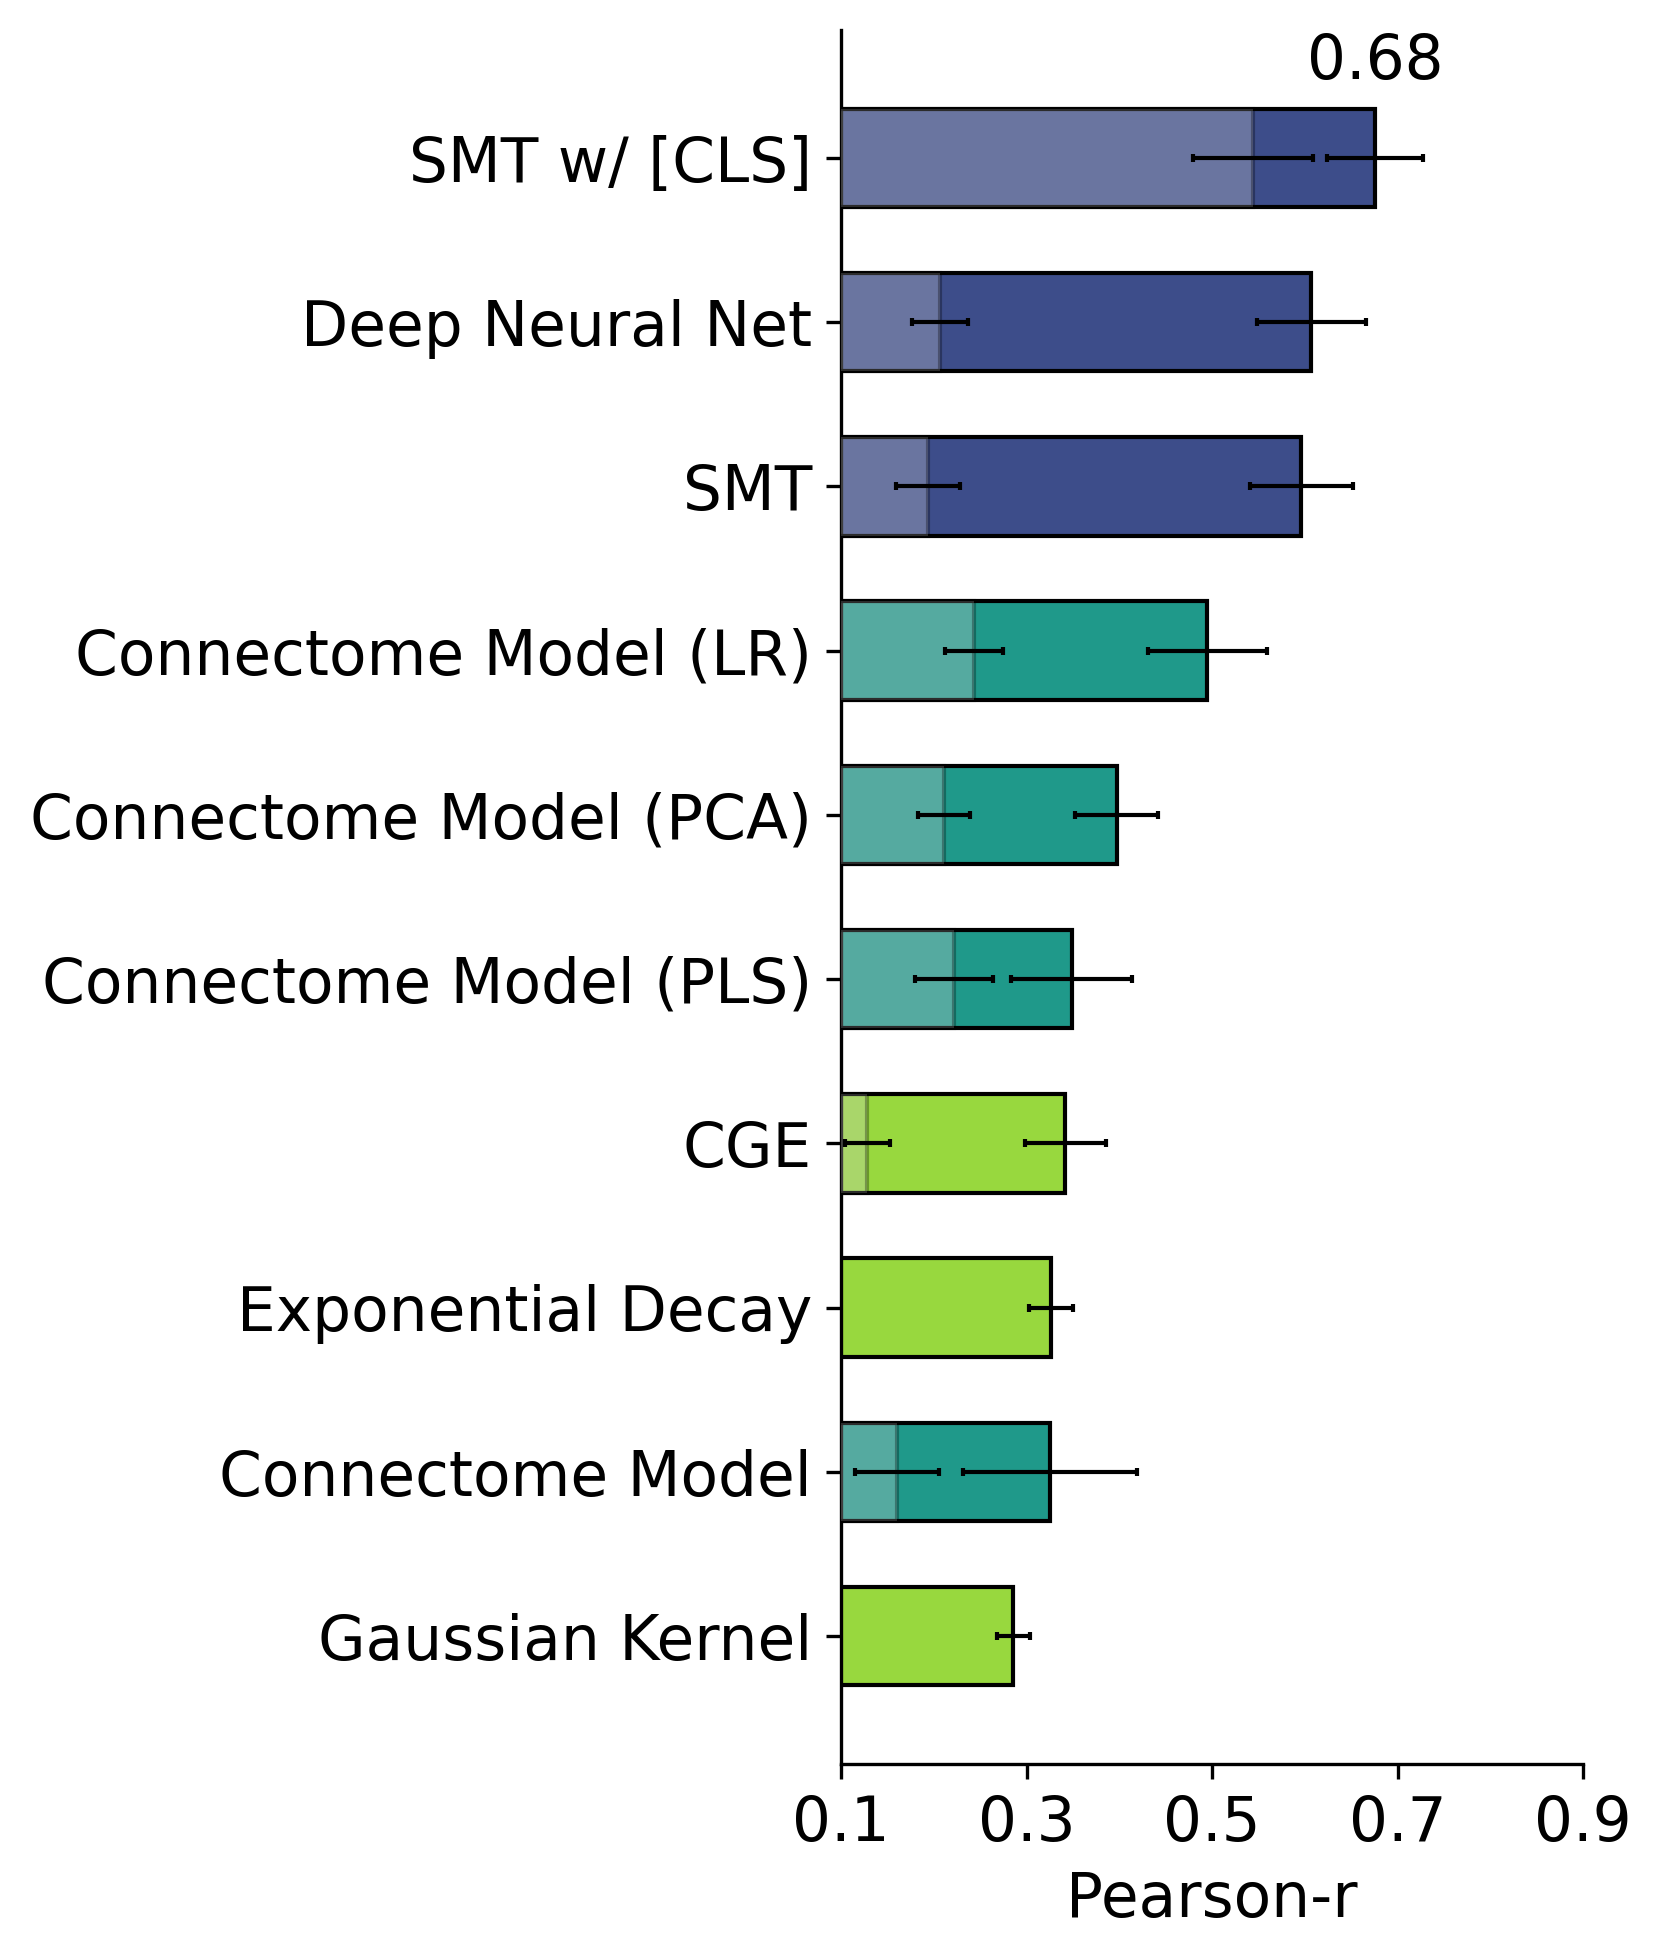

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [17]:
plot_true_vs_null_model_barchart_weighted(
    summary_true_dict=summary_dict_schaefer,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_schaefer_spin,           # cv_type='spatial', null_model='spin'
    metric="final_test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Heatmaps for UKBB vs HCP, SMT and SMT CLS

In [ ]:
model = 'shared_transformer'
null_model = 'none'
feature_type = 'transcriptome'
days = 5

_, UKBB_SMT_df = fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, exclude='HCP', days=7, return_history=True)
_, HCP_SMT_df = fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, exclude='UKBB', days=7, return_history=True)

model = 'shared_transformer_cls'
null_model = 'none'
feature_type = 'transcriptome'
days = 5
_, UKBB_SMT_CLS_df = fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, exclude='HCP', days=7, return_history=True)
_, HCP_SMT_CLS_df = fetch_and_summarize_wandb_runs_weighted_schaefer(model, null_model, feature_type, exclude='UKBB', days=7, return_history=True)

🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=none, feature_type=transcriptome
🔍 Fetching runs for: model=shared_transformer, cv_type=schaefer, null_model=none, feature_type=transcriptome
🔍 Fetching runs for: model=shared_transformer_cls, cv_type=schaefer, null_model=none, feature_type=transcriptome
🔍 Fetching runs for: model=shared_transformer_cls, cv_type=schaefer, null_model=none, feature_type=transcriptome
    train_geodesic_distance  train_inter_hemi_r  train_inter_network_Cont_r  \
10                15.213800            0.991002                    0.990054   
16                14.867723            0.990321                    0.985615   
15                16.535827            0.985627                    0.989501   
17                17.961109            0.975588                    0.984734   
4                 17.905580            0.972543                    0.979657   

    train_inter_network_Default_r  train_inter_network_DorsAttn_r  \
10          

In [128]:
subnetwork_labels = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Subcortical', 'Cerebellum']

def create_network_performance_matrix(df, subnetwork_labels):
    """Create 9x9 matrix of intra/inter network performance from dataframe and return summary metrics"""
    n = len(subnetwork_labels)
    pearson_matrix = np.zeros((n, n))
    intra_inter_matrix = np.zeros((n, 2))  # Column 0: intra, Column 1: avg inter
    
    # Iterate through each row in dataframe
    for i, (_, row) in enumerate(df.iterrows()):
        held_out_subnet = subnetwork_labels[i]
        print(held_out_subnet)
        # Get intra-network performance
        pearson_matrix[i,i] = row[f'test_intra_network_{held_out_subnet}_r']
        intra_inter_matrix[i,0] = pearson_matrix[i,i]
        
        # Get inter-network performances
        inter_performances = []
        for j, net2 in enumerate(subnetwork_labels):
            if i != j:
                pearson_matrix[i,j] = row[f'test_inter_network_{net2}_r']
                inter_performances.append(pearson_matrix[i,j])
        
        # Calculate average inter-network performance
        intra_inter_matrix[i,1] = np.mean(inter_performances)

    return pearson_matrix, intra_inter_matrix

# SMT 
ukbb_smt_subnetwork_pearson, ukbb_smt_intra_inter_matrix = create_network_performance_matrix(UKBB_SMT_df, subnetwork_labels)
hcp_smt_subnetwork_pearson, hcp_smt_intra_inter_matrix = create_network_performance_matrix(HCP_SMT_df, subnetwork_labels)

# CLS
ukbb_smt_cls_subnetwork_pearson, ukbb_smt_cls_intra_inter_matrix = create_network_performance_matrix(UKBB_SMT_CLS_df, subnetwork_labels)
hcp_smt_cls_subnetwork_pearson, hcp_smt_cls_intra_inter_matrix = create_network_performance_matrix(HCP_SMT_CLS_df, subnetwork_labels)


Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum
Vis
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Cerebellum


In [129]:
def plot_network_performance_matrix(performance_matrix, subnetwork_labels): 
    """Plot heatmap of network performance matrix for given dataframe"""
   
    
    # # Create custom colormap for performance matrix
    # colors = [
    #     (0.0, "yellow"),      # Low performance -> yellow
    #     (0.8, "green"),       # Medium performance -> green
    #     (1.0, "darkgreen")    # Excellent performance -> dark green
    # ]
    # cmap = mcolors.LinearSegmentedColormap.from_list("performance_cmap", colors)
    cmap='plasma'
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    ax = sns.heatmap(performance_matrix,
                xticklabels=subnetwork_labels,
                yticklabels=subnetwork_labels, 
                cmap=cmap,
                vmin=0,
                vmax=1,
                square=True,
                cbar_kws={'label': 'Pearson-r'},
                linecolor='black')

    # Add dashed box around diagonal elements
    for i in range(len(subnetwork_labels)):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, linestyle='--', color='black', linewidth=1.5))
        
    # Add solid lines between rows
    for i in range(len(subnetwork_labels) - 1):
        ax.axhline(y=i+1, color='black', linewidth=1.5)

    # Add outer border
    n = len(subnetwork_labels)
    ax.add_patch(plt.Rectangle((0, 0), n, n, fill=False, color='black', linewidth=2))

    plt.xlabel('Held-out target')
    plt.ylabel('Held-out source')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()



SMT

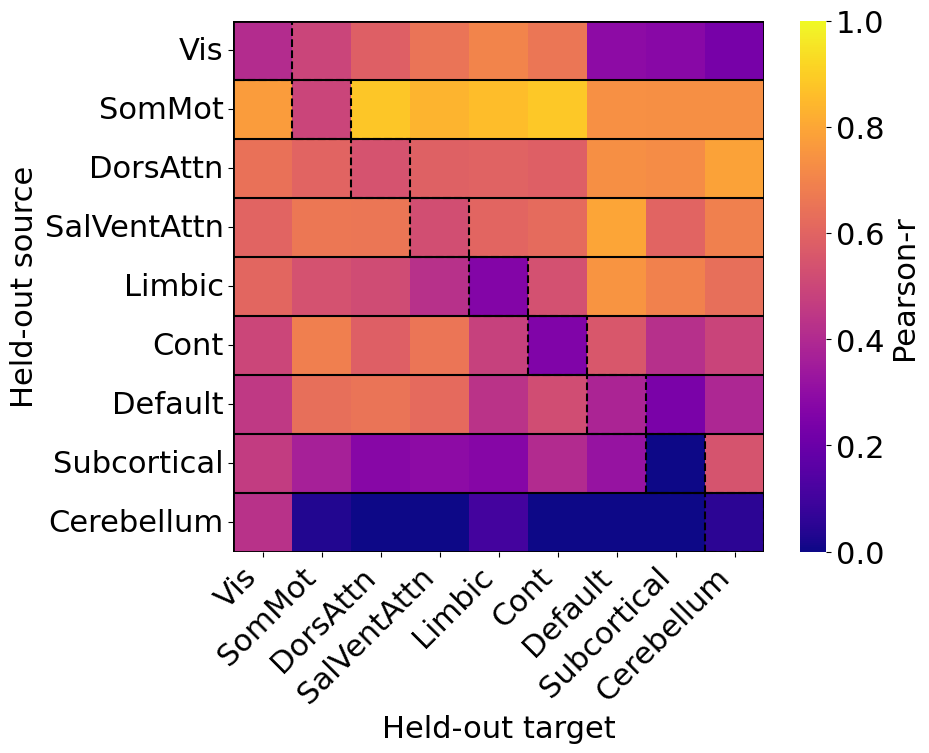

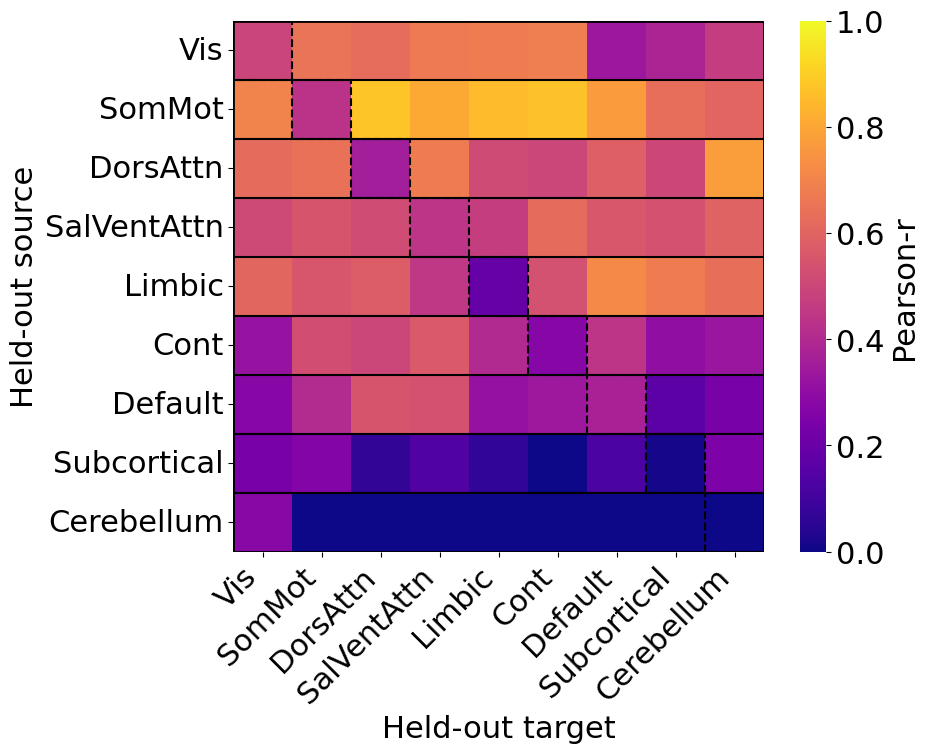

In [130]:
plot_network_performance_matrix(ukbb_smt_subnetwork_pearson, subnetwork_labels)
plot_network_performance_matrix(hcp_smt_subnetwork_pearson, subnetwork_labels)

SMT CLS

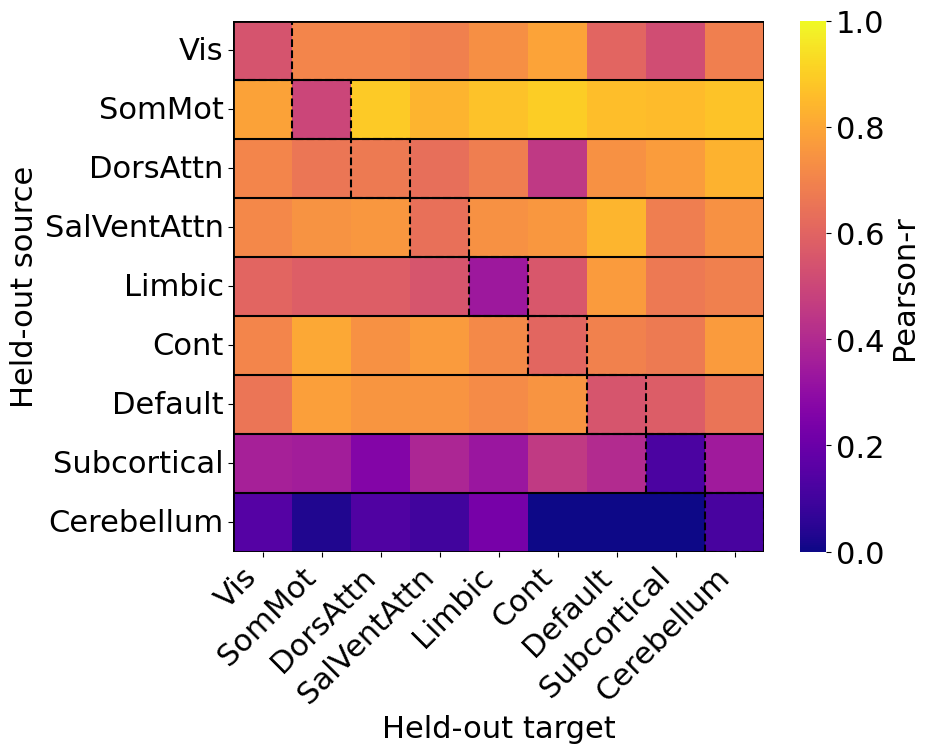

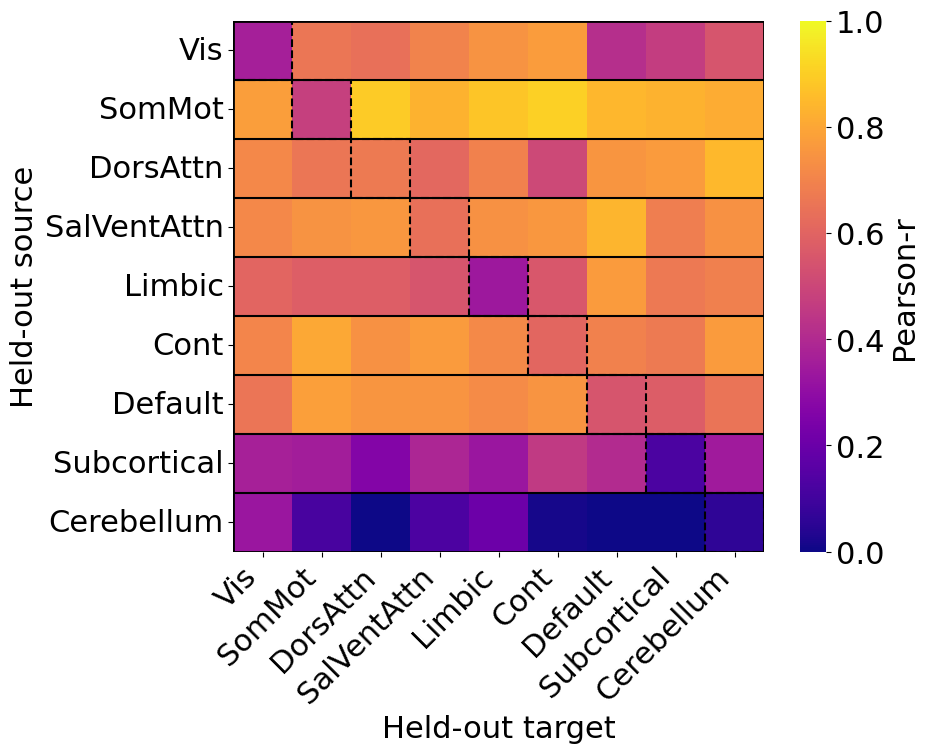

In [132]:
plot_network_performance_matrix(ukbb_smt_cls_subnetwork_pearson, subnetwork_labels)
plot_network_performance_matrix(hcp_smt_cls_subnetwork_pearson, subnetwork_labels)

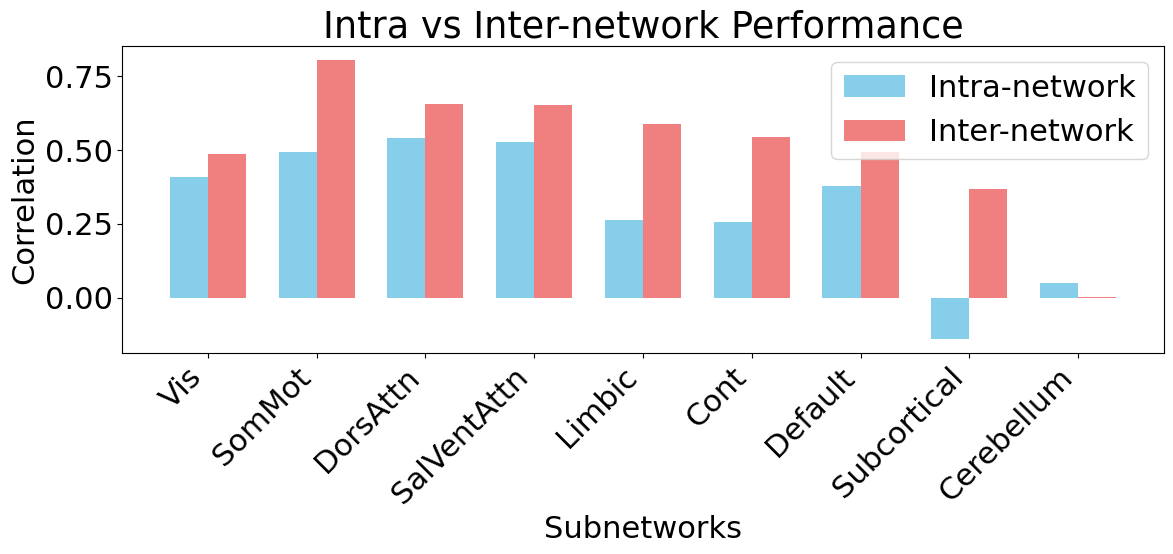

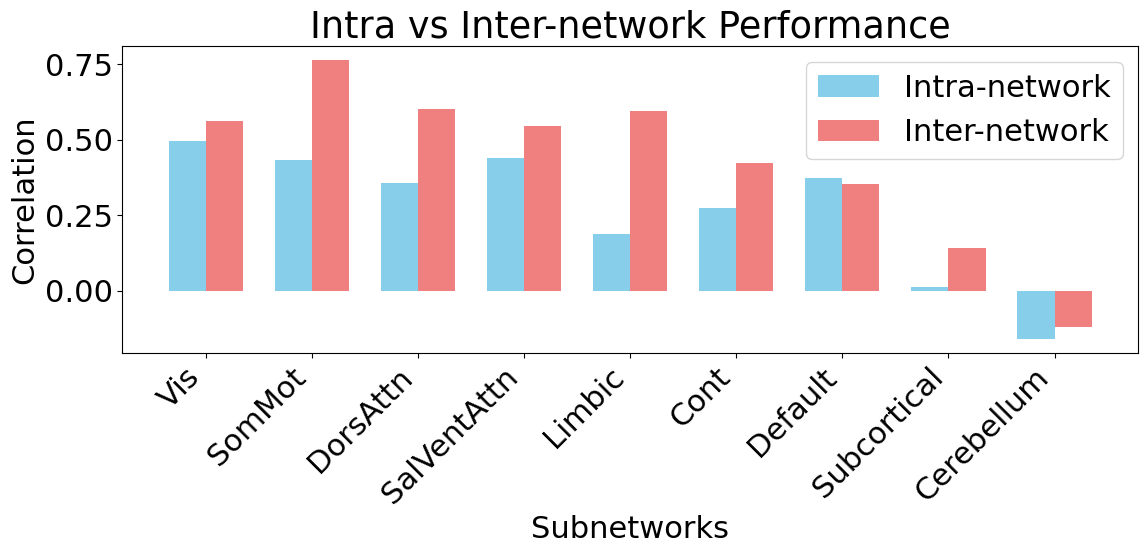

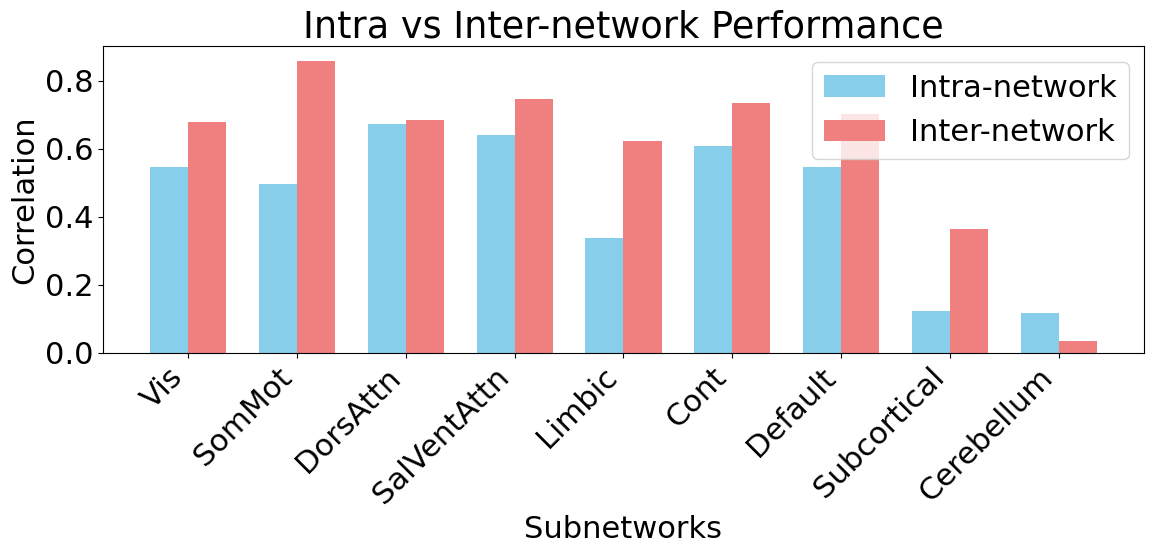

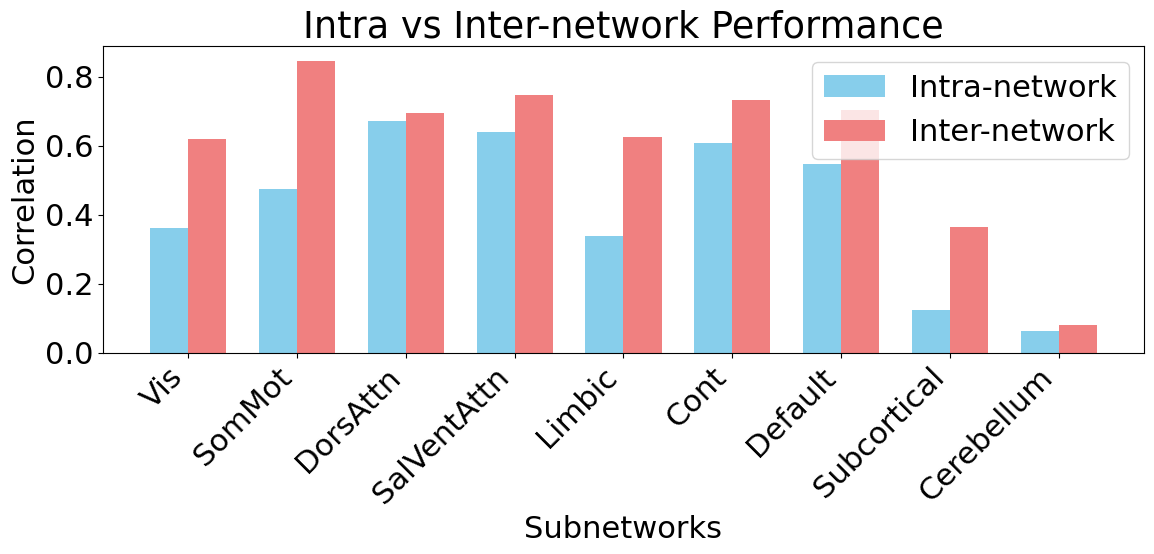

In [134]:
def plot_intra_inter_bars(intra_inter_matrix, subnetwork_labels):
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Number of subnetworks
    n_networks = len(subnetwork_labels)
    
    # Set up bar positions
    x = np.arange(n_networks)
    width = 0.35
    
    # Get intra and inter network values directly from matrix
    intra_vals = intra_inter_matrix[:,0]  # First column contains intra-network values
    inter_vals = intra_inter_matrix[:,1]  # Second column contains inter-network values
    
    # Create bars
    plt.bar(x - width/2, intra_vals, width, label='Intra-network', color='skyblue')
    plt.bar(x + width/2, inter_vals, width, label='Inter-network', color='lightcoral')
    
    # Customize plot
    plt.xlabel('Subnetworks')
    plt.ylabel('Correlation')
    plt.title('Intra vs Inter-network Performance')
    plt.xticks(x, subnetwork_labels, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for each model's intra-inter matrix
plot_intra_inter_bars(ukbb_smt_intra_inter_matrix, subnetwork_labels)
plot_intra_inter_bars(hcp_smt_intra_inter_matrix, subnetwork_labels)
plot_intra_inter_bars(ukbb_smt_cls_intra_inter_matrix, subnetwork_labels)
plot_intra_inter_bars(hcp_smt_cls_intra_inter_matrix, subnetwork_labels)